# Training Permutation-Invariant Networks


Today, we'll focus on permutation invariant neural networks. In general the answer here is graph neural networks but for this exercise we will focus on datasets that are just bags of objects, without any edges, i.e. `DeepSets` as discussed in the lecture.

## Step 0: Some imports and creating the data

In [71]:
# Imports
import os
import random
import numpy as np
import scipy as scp
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

# Set a seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Dataset Structure

First, let's create a data-generating function `make_data(N)` that produces the `N` instances following data 

* each instance has 10 objects
* each object has 1 feature that either has value $x=0$ or a nonzero value $x!=0$
* for data from class 0, a random subset of 3 objects has value 1/3
* for data from class 1, a random subset of 5 objects has value 1/5

The function `make_data(N)` should return a PyTorch feature matrix of shape `(N,10,1)` and a PyTorch label array of shape `(N,1)`

In [57]:
def make_data(N):
    total = 10  # Number of objects per instance; each instance has 10 objects

    X = np.zeros((N, total))  # Initializes an N x total matrix of zeros for features

    idx = np.random.choice(np.arange(N), size=(N//2,))  # Randomly selects half of the instances to belong to class 0

    labels = []  # Initializes an empty list to store the labels for each instance

    for i in range(N):  # Iterates over each instance
        if i in idx:  # Checks if the current instance is designated to be of class 0
            active = 3  # Sets the number of active objects for class 0 to 3
            slots = np.random.choice(np.arange(total), size=(active,), replace=False)  # Randomly selects 3 unique objects to be active
            X[i][slots] = 1/active  # Sets the value of the active objects to 1/3
            labels.append(0)  # Appends the label 0 to the labels list
        else:
            active = 5  # Sets the number of active objects for class 1 to 5
            slots = np.random.choice(np.arange(total), size=(active,), replace=False)  # Randomly selects 5 unique objects to be active
            X[i][slots] = 1/active  # Sets the value of the active objects to 1/5
            labels.append(1)  # Appends the label 1 to the labels list

    labels = np.array(labels)  # Converts the labels list to a numpy array for better performance in PyTorch

    return torch.FloatTensor(X.reshape(N, total, 1)), torch.FloatTensor(labels.reshape(-1, 1))  # Returns the feature matrix and label array, each reshaped for use in PyTorch

X,y = make_data(100)

tensor([1.])


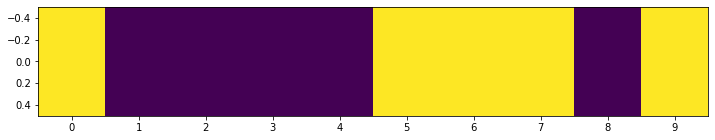

In [58]:
plt.figure(figsize=(12, 2))
plt.imshow(X[2].T, cmap='viridis', aspect='auto')
plt.xticks([i for i in range(10)])
print(y[0])
plt.show()



##  Step 1: Creating the Models: Deepsets and MLP

![Example Image](./deepset.jpg)

Now we create two models that we want to compare:

1. **DeepSet Model**
2. **Standard MLP**

### DeepSet Model

The `DeepSet` model consists of two primary components:

- **Element-wise Network**: This network processes each element of the input set independently, transforming the per-element features into a new representation. Implement this component as a small MLP, mapping $\mathbb{R} \to \mathbb{R}$ with two hidden layers, each having 5 hidden units and `Tanh` activation functions.

- **Global Set-wide Network**: A global set-wide network that takes the aggregated (pooled) representations of the objects and performs the final classification. You use a single hidden layer with also a small number of units and prepare the network for binary classification (i.e. use a sigmoid as the last operation)


The DeepSet model can be formally described as follows:
$$
\Phi(\{x_1, x_2, ..., x_n\}) = \phi\left(\sum_{i=1}^{n} \psi(x_i)\right)
$$
Where:
- $\psi: \mathbb{R} \to \mathbb{R}$ represents the element-wise network.
- $\phi$ represents the global set-wide network.
- The summation is the sum aggregation (pooling) over the transformed elements.




In [123]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()
        # Define the element-wise transformation network (psi)
        self.psi = nn.Sequential(
            nn.Linear(1, 5),  # Input from each element of the set (since ch=1)
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)  # Output the transformed element
        )
        
        # Define the global set-wise network (phi)
        self.phi = nn.Sequential(
            nn.Linear(1, 5),  # Input is aggregated features from 10 elements
            nn.Tanh(),
            nn.Linear(5, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, x):
        # x shape: [bs, num_points, ch] where bs = batch size, num_points = 10, ch = 1
        
        # Apply psi to each element in the set independently
        x_transformed = self.psi(x)  # The psi network is applied element-wise #[100, 10, 1]
        # Sum pooling over the elements of the set
        x_pooled = x_transformed.sum(dim=1)  # Sum across the num_points dimension #out:[100, 1]
        # Apply the global set-wise network phi
        y = self.phi(x_pooled)  # The phi network processes the aggregated features
        
        return y


In [143]:
#TO REMOVE

class DeepSet(nn.Module):
    def __init__(self, agg_func):
        super(DeepSet, self).__init__()
        # Define the element-wise transformation network (psi)
        self.psi = nn.Sequential(
            nn.Linear(1, 5),  # Input from each element of the set (since ch=1)
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)  # Output the transformed element
        )
        
        # Define the global set-wise network (phi)
        self.phi = nn.Sequential(
            nn.Linear(1, 5),  # Input is aggregated features from 10 elements
            nn.Tanh(),
            nn.Linear(5, 1),
            nn.Sigmoid()  # Binary classification
        )

        self.agg_func = agg_func  # new attribute for aggregation function

    def forward(self, x):
        # x shape: [bs, num_points, ch] where bs = batch size, num_points = 10, ch = 1
    
        # Apply psi to each element in the set independently
        x_transformed = self.psi(x)  # The psi network is applied element-wise #[100, 10, 1]

        if self.agg_func == 'max':
            x_pooled = x_transformed.max(dim=1)[0]  # Use max
        if self.agg_func == 'min':
            x_pooled = x_transformed.min(dim=1)[0]  # Use min
        if self.agg_func == 'mean':
            x_pooled = x_transformed.mean(dim=1)  # Use mean
        elif self.agg_func == 'std':
            x_pooled = x_transformed.std(dim=1)  # Use std
        else:
            x_pooled = x_transformed.sum(dim=1)  # Default to sum

        # Apply the global set-wise network phi
        y = self.phi(x_pooled)  # The phi network processes the aggregated features
        
        return y

For the MLP, just use the following standard network architecture that you have already had in your past excercises:

In [144]:
class MLP(nn.Module):
    def __init__(self, input_size=10, Nhidden=5):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, Nhidden),
            nn.ReLU(),
            nn.Linear(Nhidden, Nhidden),
            nn.ReLU(),
            nn.Linear(Nhidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

## Step 2: Writing the Training Loop

Write a training loop that takes an untrained model and trains it for some number of steps (e.g. 2000)
using the Adam optimizer. At each loop iteration, draw random data from `make_data` (this is effectively an infinitely large training dataset)


* Train on binary cross entropy as a loss function.
* As you are training, track the loss value
* The `train(model)` function should return both the trained model as well as the loss history
* Then, train both the Deep Set as well as the MLP!

In [145]:
def train(model):
    # Create an optimizer object, here Adam
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    opt.zero_grad()
    # Initialize a list to store the loss values at each training step, allowing us to visualize the loss trajectory later.
    trajectory = []

    # Loop over N iterations to train the model
    for i in range(2000):
        # Generate data on the fly
        X, y = make_data(100)

        # Forward pass: Compute the model's predictions for the input batch.
        p = model(X)
        # Compute the binary cross-entropy loss between the predictions and the true labels.
        loss = torch.nn.functional.binary_cross_entropy(p, y)

        # Record the loss value
        trajectory.append(float(loss))
        # Backward pass
        loss.backward()
        # Step the optimizer to update the model's parameters based on the gradients.
        opt.step()
        # Reset the gradients of all model parameters to zero for the next iteration.
        opt.zero_grad()

        # Every 500 iterations, print the current loss to monitor progress visually.
        if i % 500 == 0:
            print(float(loss))

    # Return the trained model and the array of loss values collected during training.
    return model, np.array(trajectory)


In [147]:
trained_deepset,losscurve_deepset = train(DeepSet(agg_func='sum'))
print('Training DeepSet is Finished!')
trained_mlp,losscurve_mlp = train(MLP())
print('Training MLP is Finished!')

0.6875457167625427
0.27000758051872253
0.02936648763716221
0.010599737986922264
Training DeepSet is Finished!


## Step 3: Comparing MLP and DeepSet
### Tasks:
* Write a function `count_params(model)` that returns the number of parameters for the neural network
* Compute the number of parameters for both trained models
* Plot the loss curve for both the MLP as well as the DeepSet 

### Optional Hint or riddle ;):
In a land where tensors thrive and dimensions intertwine, every element seeks to be counted, not for their size or shape, but for their sheer number. 
If you wish to count them all, from the smallest scalar to vast arrays, which PyTorch spell must you cast to reveal their total count?

In [136]:
#TODO: Define the function count_params(model)
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_deepset = count_params(trained_deepset)
n_mlp = count_params(trained_mlp)

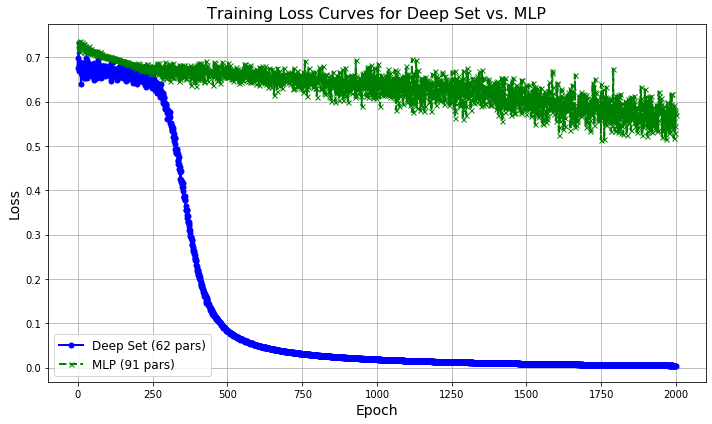

In [137]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(losscurve_deepset, label=f'Deep Set ({n_deepset} pars)', color='blue', linestyle='-', linewidth=2, marker='o', markersize=5)
plt.plot(losscurve_mlp, label=f'MLP ({n_mlp} pars)', color='green', linestyle='--', linewidth=2, marker='x', markersize=5)
plt.title('Training Loss Curves for Deep Set vs. MLP', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 4: Experimenting with Aggregation Functions in DeepSet

In this step, you will explore the impact of various aggregation functions on the performance of the DeepSet model. Aggregation functions play an important role in set-based neural architectures as global G-invariant pooling layers. 
The original DeepSet model incorporates sum operation to do the aggregation of information. 

#### Task:
* Your task here is to think of at least two other aggregation functions instead and implement them. Then compare the results with the original DeepSet model. You can modify the original DeepSet model and add the following option to the model to input a control attribute on the aggregation function.


**Example modifications to the DeepSet class**:
```python
class DeepSet(nn.Module):
    def __init__(self, agg_func):
        super(DeepSet, self).__init__()
        self.psi = ...  # unchanged
        self.phi = ...  # unchanged
        self.agg_func = agg_func  # new attribute for aggregation function

    def forward(self, x):
        x_transformed = self.psi(x)
        if self.agg_func == 'agg1':
            x_aggregated = ...
        elif self.agg_func == 'agg2':
            x_aggregated = ...
        else:
            x_aggregated = x_transformed.sum(dim=1)  # Default to sum
        y = self.phi(x_aggregated)
        return y
```



In [ ]:
#TO REMOVE

class DeepSet(nn.Module):
    def __init__(self, agg_func):
        super(DeepSet, self).__init__()
        # Define the element-wise transformation network (psi)
        self.psi = nn.Sequential(
            nn.Linear(1, 5),  # Input from each element of the set (since ch=1)
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)  # Output the transformed element
        )
        
        # Define the global set-wise network (phi)
        self.phi = nn.Sequential(
            nn.Linear(1, 5),  # Input is aggregated features from 10 elements
            nn.Tanh(),
            nn.Linear(5, 1),
            nn.Sigmoid()  # Binary classification
        )

        self.agg_func = agg_func  # new attribute for aggregation function

    def forward(self, x):
        # x shape: [bs, num_points, ch] where bs = batch size, num_points = 10, ch = 1
    
        # Apply psi to each element in the set independently
        x_transformed = self.psi(x)  # The psi network is applied element-wise #[100, 10, 1]

        if self.agg_func == 'max':
            x_pooled = x_transformed.max(dim=1)[0]  # Use max
        if self.agg_func == 'min':
            x_pooled = x_transformed.min(dim=1)[0]  # Use min
        if self.agg_func == 'mean':
            x_pooled = x_transformed.mean(dim=1)  # Use mean
        elif self.agg_func == 'std':
            x_pooled = x_transformed.std(dim=1)  # Use std
        else:
            x_pooled = x_transformed.sum(dim=1)  # Default to sum

        # Apply the global set-wise network phi
        y = self.phi(x_pooled)  # The phi network processes the aggregated features
        
        return y

## Step 5: Verify the Permutation Invariance

The advantage of encoding known symmetries into the network is not only that the learning is faster but of course also that the symmetries hold exactly.

* Take an sample of the data and produce 3 random permutations of the point in it via `np.random.permutation`
* Evaluate the model on each of these permuted inputs
* Compare  he model outputs and deduce that the deep set is indeed permutation invariant, while the MLP is not

In [118]:
# Randomly permutes indices from 0 to 9, generating a new order for the elements of the sample.
perm0 = np.random.permutation(10)
perm1 = np.random.permutation(10)
perm2 = np.random.permutation(10)

# Selects the first instance from the dataset `X`, applies the first permutation, and reshapes it to match model input requirements.
testX1 = torch.FloatTensor(X[0][perm0]).reshape(1,10,1)
# Same as above but applies the second permutation to the first instance.
testX2 = torch.FloatTensor(X[0][perm1]).reshape(1,10,1)
# Same as above but applies the third permutation to the first instance.
testX3 = torch.FloatTensor(X[0][perm2]).reshape(1,10,1)

print('For DeepSets')
for XX in [testX1,testX2,testX3]:
    print(trained_deepset(XX).detach())

print('For MLP')
for XX in [testX1,testX2,testX3]:
    print(trained_mlp(XX).detach())


For DeepSets
tensor([[0.9977]])
tensor([[0.9977]])
tensor([[0.9977]])
For MLP
tensor([[0.4158]])
tensor([[0.6421]])
tensor([[0.6554]])


## Step 6: Bonus Question

* Remember the Geometric Deep Learning Blueprint. Non-linearity was also a crucial factor. In roder to see this, in the DeepSet try removing the non-Linearity in the element wise network and check the model performance. Can you explain what is happening and why?